# Code for peak shaving optimization

In [57]:
#import packages
import numpy as np
import pandas as pd
import cvxpy as cp
import gurobipy
from datetime import datetime, time, date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import Counter

# Data pre-processing

In [58]:
#Add date parser to read in the date as an actual date object
date_parser = lambda x: datetime.strptime(x, '%d-%b-%Y')
demand = pd.read_csv('./data/ColumbiaDemand.csv', parse_dates=['Date'], date_parser=date_parser) 
demand.head()
#Restructure into one list of demands for each month

,Date,TotalDemand [kWh],Period01 [kWh],Period02 [kWh],Period03 [kWh],Period04 [kWh],Period05 [kWh],Period06 [kWh],Period07 [kWh],Period08 [kWh],...,Period87 [kWh],Period88 [kWh],Period89 [kWh],Period90 [kWh],Period91 [kWh],Period92 [kWh],Period93 [kWh],Period94 [kWh],Period95 [kWh],Period96 [kWh]
0,2018-01-01,72686.88,734.40,731.52,727.20,735.84,730.08,728.64,731.52,730.08,...,740.16,741.60,734.40,735.84,735.84,730.08,725.76,731.52,728.64,724.32
1,2018-01-02,73594.08,728.64,727.20,728.64,727.20,732.96,734.40,734.40,737.28,...,743.04,741.60,741.60,738.72,750.24,743.04,750.24,738.72,738.72,743.04
2,2018-01-03,73440.00,745.92,743.04,745.92,744.48,741.60,734.40,735.84,734.40,...,734.40,732.96,721.44,714.24,721.44,725.76,727.20,724.32,731.52,722.88
3,2018-01-04,73967.04,718.56,718.56,724.32,727.20,720.00,724.32,725.76,720.00,...,747.36,744.48,735.84,734.40,741.60,743.04,738.72,741.60,740.16,735.84
4,2018-01-05,74625.12,745.92,743.04,744.48,741.60,737.28,743.04,747.36,748.80,...,767.52,768.96,760.32,758.88,756.00,756.00,753.12,754.56,750.24,745.92


In [63]:
#Drop total demand columns and pivot
demand_unpivoted = demand[demand.columns.difference(['TotalDemand [kWh]'])].melt(id_vars=['Date'], var_name='period', value_name='demand')
#Make sure to sore by date and period
demand_unpivoted = demand_unpivoted.sort_values(by=['Date','period']).reset_index(drop=True)
demand_unpivoted['year'] = demand_unpivoted['Date'].dt.year
demand_unpivoted['month'] = demand_unpivoted['Date'].dt.month
demand_unpivoted['weekday'] = demand_unpivoted['Date'].dt.weekday
demand_unpivoted = demand_unpivoted.fillna(0)
demand_unpivoted.head() 

,Date,period,demand,year,month,weekday
0,2018-01-01,Period01 [kWh],734.40,2018,1,0
1,2018-01-01,Period02 [kWh],731.52,2018,1,0
2,2018-01-01,Period03 [kWh],727.20,2018,1,0
3,2018-01-01,Period04 [kWh],735.84,2018,1,0
4,2018-01-01,Period05 [kWh],730.08,2018,1,0


## Example of data selection for a single month (and year)

In [60]:
jan_2018 = demand_unpivoted[(demand_unpivoted['year']==2018) & (demand_unpivoted['month'] == 1)]
# Add column for rolling sum of current row and preious for demand\n",
jan_2018['rolling_demand'] = jan_2018[['demand']].rolling(2).sum()
jan_2018.head()

/var/folders/8w/yzz7q0p146x4qrt7dwp0mhy40000gn/T/ipykernel_32319/2184305333.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jan_2018['rolling_demand'] = jan_2018[['demand']].rolling(2).sum()


,Date,period,demand,year,month,rolling_demand
0,2018-01-01,Period01 [kWh],734.40,2018,1,NaN
1,2018-01-01,Period02 [kWh],731.52,2018,1,1465.92
2,2018-01-01,Period03 [kWh],727.20,2018,1,1458.72
3,2018-01-01,Period04 [kWh],735.84,2018,1,1463.04
4,2018-01-01,Period05 [kWh],730.08,2018,1,1465.92


In [61]:
jan_2018_demand = np.array(jan_2018['demand'])
jan_2018_demand

array([734.4 , 731.52, 727.2 , ..., 705.6 , 708.48, 711.36])

### Find the peak period for a month
Assumptions: 
* 15-minute intervals are continuous throughout the month, so one day continues into the next day
* If one of the 2 periods of peak demand occur during the high/low tension service then the higher price is assumed for the peak demand charge
    * i.e. peak periods occur at 7:45am and 8am, assume the peak demand charge is $13.96+$4.21

In [62]:
#Print location where the demand is a maximum - get the period and see the charges
print('rolling max demand is ', jan_2018['rolling_demand'].max(), 'at index ',jan_2018['rolling_demand'].argmax())
print('The max periods are: ', jan_2018.loc[jan_2018['rolling_demand'].argmax()-1]['period'], ' and ', jan_2018.loc[jan_2018['rolling_demand'].argmax()]['period'])
print('Peak periods at hours: ', str(int(jan_2018.loc[jan_2018['rolling_demand'].argmax()-1]['period'].split('Period')[1].split(' ')[0])/4), ' and ', str(int(jan_2018.loc[jan_2018['rolling_demand'].argmax()]['period'].split('Period')[1].split(' ')[0])/4))
print('Look at the data at that period: ')
jan_2018[jan_2018['rolling_demand'].argmax()-2:jan_2018['rolling_demand'].argmax()+2]

rolling max demand is  1905.12 at index  720
The max periods are:  Period48 [kWh]  and  Period49 [kWh]
Peak periods at hours:  12.0  and  12.25
Look at the data at that period: 


,Date,period,demand,year,month,rolling_demand
718,2018-01-08,Period47 [kWh],947.52,2018,1,1889.28
719,2018-01-08,Period48 [kWh],953.28,2018,1,1900.80
720,2018-01-08,Period49 [kWh],951.84,2018,1,1905.12
721,2018-01-08,Period50 [kWh],953.28,2018,1,1905.12


## Analysis of peak demand period

In [66]:
peak_analysis = pd.DataFrame(columns=['month','year','peak_demand','periods', 'hours','weekday', 'peak_cost'])
summer_charge_tiers = [16.66, 18.44, 9.15]
other_charge_tiers = [4.21, 13.96]
for year in [2018, 2019]:
    for month in range(1,13):
        print(f'{month}/{year}')
        df = demand_unpivoted[(demand_unpivoted['year']==year) & (demand_unpivoted['month'] == month)].reset_index(drop=True)
        # Add column for rolling sum of current row and preious for demand\n",
        df['rolling_demand'] = df[['demand']].rolling(2).sum()
        #Print location where the demand is a maximum - get the period and see the charges
        #Add row to dataframe of resulsts
        peak_demand = df['rolling_demand'].max()
        period1 = df.loc[df['rolling_demand'].argmax()-1]['period']
        period2 = df.loc[df['rolling_demand'].argmax()]['period']
        hour1 = int(df.loc[df['rolling_demand'].argmax()-1]['period'].split('Period')[1].split(' ')[0])/4
        hour2 = int(df.loc[df['rolling_demand'].argmax()]['period'].split('Period')[1].split(' ')[0])/4
        #Figure out if it is a weekday
        weekday1 = df.loc[df['rolling_demand'].argmax()-1]['weekday']
        weekday2 = df.loc[df['rolling_demand'].argmax()]['weekday']
        #If the hour is in a peak period, then mark as such
        #Between 8am-10pm on weekdays
        if (hour1 >= 8) and (hour1 <=22) and ((weekday1<5) or (weekday2<5)) :
            # Charge for June, July, August, September
            if month in [6, 7, 8, 9]:
                #Between 8am-6pm
                if hour1 <= 18:
                    peak_charge = summer_charge_tiers[0] + summer_charge_tiers[1] + summer_charge_tiers[2]
                else:
                    peak_charge = summer_charge_tiers[0] + summer_charge_tiers[1]
            else:
                peak_charge = other_charge_tiers[0] + other_charge_tiers[1]
        else:
            # Charge for June, July, August, September
            if month in [6, 7, 8, 9]:
                peak_charge = summer_charge_tiers[0]
            else:
                peak_charge = other_charge_tiers[0]

        peak_analysis.loc[len(peak_analysis.index)] =[month, year, peak_demand,[period1,period2], [hour1, hour2], [weekday1, weekday2], peak_charge]
        print('rolling max demand is ', peak_demand, 'at index ',df['rolling_demand'].argmax())
        print('The max periods are: ', period1, ' and ', period2)
        print('Peak periods at hours: ', str(hour1), ' and ', str(hour2))

1/2018
rolling max demand is  1905.12 at index  720
The max periods are:  Period48 [kWh]  and  Period49 [kWh]
Peak periods at hours:  12.0  and  12.25
2/2018
rolling max demand is  1716.48 at index  1222
The max periods are:  Period70 [kWh]  and  Period71 [kWh]
Peak periods at hours:  17.5  and  17.75
3/2018
rolling max demand is  1748.1599999999999 at index  2846
The max periods are:  Period62 [kWh]  and  Period63 [kWh]
Peak periods at hours:  15.5  and  15.75
4/2018
rolling max demand is  1716.48 at index  2352
The max periods are:  Period48 [kWh]  and  Period49 [kWh]
Peak periods at hours:  12.0  and  12.25
5/2018
rolling max demand is  2056.32 at index  1409
The max periods are:  Period65 [kWh]  and  Period66 [kWh]
Peak periods at hours:  16.25  and  16.5
6/2018
rolling max demand is  2224.8 at index  1686
The max periods are:  Period54 [kWh]  and  Period55 [kWh]
Peak periods at hours:  13.5  and  13.75
7/2018
rolling max demand is  2367.3599999999997 at index  249
The max periods 

In [67]:
print('Summer peak cost: ', peak_analysis[peak_analysis['month'].isin([6,7,8,9])]['peak_cost'].unique())
print('Other Month peak cost: ', peak_analysis[-peak_analysis['month'].isin([6,7,8,9])]['peak_cost'].unique())

Summer peak cost:  [44.25]
Other Month peak cost:  [18.17]


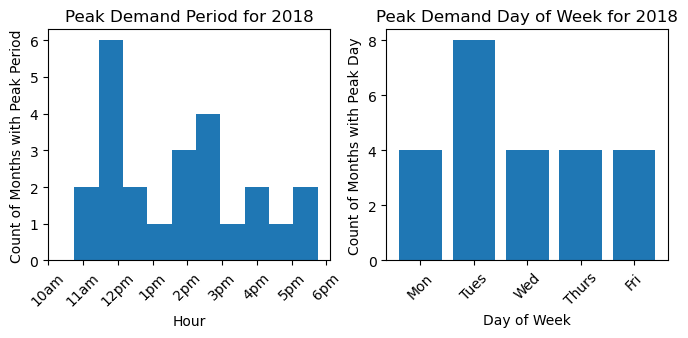

In [115]:
hours = np.array(peak_analysis[peak_analysis['year'] == 2018]['hours']).flatten()
hours = [item for sublist in hours for item in sublist]
weekdays = np.array(peak_analysis[peak_analysis['year'] == 2018]['weekday']).flatten()
weekdays = [item for sublist in weekdays for item in sublist]
weekdays = Counter(weekdays)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
_ = plt.hist(hours)
_ = plt.xticks(ticks=[10, 11, 12, 13, 14, 15, 16, 17, 18], labels=['10am','11am','12pm','1pm','2pm','3pm','4pm','5pm','6pm'], rotation=45)
_ = plt.title('Peak Demand Period for 2018')
_ = plt.xlabel('Hour')
_ = plt.ylabel('Count of Months with Peak Period')

plt.subplot(1,2,2)
_ = plt.bar(weekdays.keys(), weekdays.values())
_ = plt.xticks(ticks=[0,1,2,3,4], labels=['Mon','Tues','Wed','Thurs','Fri'], rotation=45)
_ = plt.title('Peak Demand Day of Week for 2018')
_ = plt.xlabel('Day of Week')
_ = plt.ylabel('Count of Months with Peak Day')

From the above analysis, we see that over all months, the peak demand occurs during the most expensive time period. We can assume this will be the case throughout our analysis and set B = most expensive peak demand charge option for that month.

# Optimization

In [10]:
jan_2018_demand

array([734.4 , 731.52, 727.2 , ..., 705.6 , 708.48, 711.36])

In [11]:
def run_optimization(D, P, battery, month, e_0):
    """
    Description: Code to run the optimization procedure

    Inputs:
        D, np.array: demand for each period
        P, float: battery power rating
        battery, str : battery option either "li-ion" or "thermal"
        month, int: month of year
        e_0, float: energy stored in the battery and the start of the month
    
    Output:
        Results of optimization
    """
    #Update variables depending on battery type
    if battery == 'li-ion':
        #battery efficiency
        eta = .95
        #Energy rating
        E = 4*P
        #Define additional variables
        cost_P = 300*P
        cost_E = 200*E

    elif battery == 'thermal':
        #battery efficiency
        eta = .7
        #Energy rating
        E = 12*P
        #Define additional variables
        cost_P = 500*P
        cost_E = 50*E

    else:
        print('optimizing without battery...')
        P=0
        eta = .95
        E = 0
        cost_P = 0
        cost_E = 0
    
    #Update peak charges depending on time of year:
    if month in [6, 7, 8, 9]:
        B = 9.15 + 18.44 + 16.66
    else:
        B = 4.21 + 13.96
        
    #Cost of electricity
    C = .13
    
    # Decision Variables
    #Storage discharge power
    d = cp.Variable(len(D), nonneg=True)
    # Storage charge power
    q = cp.Variable(len(D), nonneg=True)
    # Energy storged
    e = cp.Variable(len(D), nonneg=True)
    # peak demand
    p = cp.Variable(nonneg=True)

    # Initialize an empty constraint set
    con_set_1 = []  

    for t in range(len(D)):
        #These if statements relate to if a charge/discharge is provided
        #Can't discharge more than the power rating of battery
        con_set_1.append(d[t] <= P)
        #Can't charge more than the power rating of battery
        con_set_1.append(q[t] <= P)
        # #Can't store more energy than capacity
        con_set_1.append(e[t] <= E)
        if t == 0:
            # state-of charge constraint 1 - use final state-of-energy
            # from previous month
            con_set_1.append(e[t] - e_0 == q[t]*eta - d[t]/eta)
        elif t == len(D)-1:
            # # peak demand identification
            con_set_1.append(p >= D[t] - d[t] + q[t])
        else:
            # # state-of charge constraint 1
            con_set_1.append(e[t] - e[t-1] == q[t]*eta - d[t]/eta)
            # # peak demand identification
            con_set_1.append(p >= D[t] - d[t] + q[t] + D[t+1] - d[t+1] + q[t+1])

    #Define Objective - BP + sum over t
    #mutlipy by 2 because p is only a half hour increment right now
    obj = cp.Minimize(2*B*p + C*sum(D - d + q))

    # Solve the problem
    prob1 = cp.Problem(obj, con_set_1)
    prob1.solve(solver = "GUROBI", reoptimize=True)
    prob1.solve();

    return(prob1.value, cost_E, cost_P, e, p, d, q)

In [43]:
#Run optimization for 2/2018 using code below
monthly_cost, cost_E, cost_P, e, p, d, q, obj_cost = run_optimization(
    D = np.array(demand_unpivoted[(demand_unpivoted['year']==2018) & (demand_unpivoted['month'] == 2)]['demand']),
    P = 50,
    battery = 'thermal',
    month = 2,
    e_0=0)

In [14]:
monthly_results = pd.DataFrame(columns=['month', 'monthly_cost', 'cost_E', 'cost_P', 'P', 'battery_type', 'end_e'])
for battery in ['No','thermal','li-ion']:
    if battery == 'thermal':
        powers = np.arange(200,750,50)
    elif battery == 'li-ion':
        powers = np.arange(200,750,50)
    else:
        powers = [0]
    for power in powers:
        for month in range(1,13):
            demand_array = np.array(demand_unpivoted[(demand_unpivoted['year']==2018) & (demand_unpivoted['month'] == month)]['demand'])
            print(f'Optimizing {month}/2018 with {power} kW {battery} battery...')
            if month == 1:
                monthly_cost, cost_E, cost_P, e, p, d, q = run_optimization(D = demand_array, P = power, battery = battery, month = month, e_0=0)
                #update the energy stored in the battery based on the final period
                e_0 = e.value[-1]
            else:
                monthly_cost, cost_E, cost_P, e, p, d, q = run_optimization(D = demand_array, P = power, battery = battery, month = month, e_0=e_0)
                #update the energy stored in the battery based on the final period
                e_0 = e.value[-1]
            monthly_results.loc[len(monthly_results.index)] =[month, monthly_cost, cost_E,cost_P, power, battery, e_0]

Optimizing 1/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 2/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 3/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 4/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 5/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 6/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 7/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 8/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 9/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 10/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 11/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 12/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 1/2018 with 200 kW thermal battery...
Optimizing 2/2018 with 200 kW thermal battery...
Optimizing 3/2018 with 200 kW therm

In [15]:
cost_0 = round(np.sum(monthly_results[monthly_results['P'] == 0]['monthly_cost']),0)
for battery in ['thermal','li-ion']:
    print(f'{battery} results:')
    battery_results = monthly_results[monthly_results['battery_type'] == battery]
    for P in battery_results['P'].unique():
        cost = round(np.sum(battery_results[battery_results['P'] == P]['monthly_cost']),0)
        cost_diff =  cost_0 - cost
        long_term_cost_diff = cost_diff*10
        battery_cost = round(battery_results[battery_results['P'] == P]['cost_E'].unique().item()+battery_results[battery_results['P'] == P]['cost_P'].unique().item(),0)
        print(f'\t{P}kW {battery} battery: ${cost:,} operating and ${battery_cost:,} for battery - 10-year amount saved: ${long_term_cost_diff-battery_cost:,}' )

thermal results:
	200kW thermal battery: $4,904,949.0 operating and $220,000 for battery - 10-year amount saved: $742,350.0
	250kW thermal battery: $4,895,430.0 operating and $275,000 for battery - 10-year amount saved: $782,540.0
	300kW thermal battery: $4,888,698.0 operating and $330,000 for battery - 10-year amount saved: $794,860.0
	350kW thermal battery: $4,883,198.0 operating and $385,000 for battery - 10-year amount saved: $794,860.0
	400kW thermal battery: $4,878,447.0 operating and $440,000 for battery - 10-year amount saved: $787,370.0
	450kW thermal battery: $4,874,288.0 operating and $495,000 for battery - 10-year amount saved: $773,960.0
	500kW thermal battery: $4,870,793.0 operating and $550,000 for battery - 10-year amount saved: $753,910.0
	550kW thermal battery: $4,867,481.0 operating and $605,000 for battery - 10-year amount saved: $732,030.0
	600kW thermal battery: $4,864,482.0 operating and $660,000 for battery - 10-year amount saved: $707,020.0
	650kW thermal batte

## Optimize using Forecasted Demand for 2019:

In [14]:
def run_optimization_actual_demand(D, P, battery, month, e_0, d, q):
    """
    Description: Code to run the optimization procedure

    Inputs:
        D, np.array: demand for each period
        P, float: battery power rating
        battery, str : battery option either "li-ion" or "thermal"
        month, int: month of year
        e_0, float: energy stored in the battery and the start of the month
        d, np.array: battery discharge for each period
        q, np.array: battery charge for each period
    
    Output:
        Results of optimization
    """
    #Update variables depending on battery type
    if battery == 'li-ion':
        #battery efficiency
        eta = .95
        #Energy rating
        E = 4*P
        #Define additional variables
        cost_P = 300*P
        cost_E = 200*E

    elif battery == 'thermal':
        #battery efficiency
        eta = .7
        #Energy rating
        E = 12*P
        #Define additional variables
        cost_P = 500*P
        cost_E = 50*E

    else:
        print('optimizing without battery...')
        P=0
        eta = 1
        E = 0
        cost_P = 0
        cost_E = 0
    
    #Update peak charges depending on time of year:
    if month in [6, 7, 8, 9]:
        B = 9.15 + 18.44 + 16.66
    else:
        B = 4.21 + 13.96
        
    #Cost of electricity
    C = .13
    
    # Decision Variables
    #Storage discharge power
    # d = cp.Variable(len(D), nonneg=True)
    # Storage charge power
    # q = cp.Variable(len(D), nonneg=True)
    # Energy storged
    e = cp.Variable(len(D), nonneg=True)
    # peak demand
    p = cp.Variable(nonneg=True)

    # Initialize an empty constraint set
    con_set_1 = []  

    for t in range(len(D)):
        #These if statements relate to if a charge/discharge is provided
        #Can't discharge more than the power rating of battery
        # con_set_1.append(d[t] <= P)
        #Can't charge more than the power rating of battery
        # con_set_1.append(q[t] <= P)
        # #Can't store more energy than capacity
        con_set_1.append(e[t] <= E)
        if t == 0:
            # state-of charge constraint 1 - assume battery is empty
            # before month starts
            con_set_1.append(e[t] - e_0 == q[t]*eta - d[t]/eta)
        elif t == len(D)-1:
            # # peak demand identification
            con_set_1.append(p >= D[t] - d[t] + q[t])
        else:
            # # state-of charge constraint 1
            con_set_1.append(e[t] - e[t-1] == q[t]*eta - d[t]/eta)
            # # peak demand identification
            con_set_1.append(p >= D[t] - d[t] + q[t] + D[t+1] - d[t+1] + q[t+1])

    #Define Objective - BP + sum over t
    #mutlipy by 2 because p is only a half hour increment right now
    obj = cp.Minimize(2*B*p + C*sum(D - d + q))

    # Solve the problem
    prob1 = cp.Problem(obj, con_set_1)
    prob1.solve(solver = "GUROBI", reoptimize=True)
    prob1.solve();

    # print(f'\tCost from electricity: ${prob1.value:,.0f}')
    # print(f'\tCost from battery: ${(cost_E+cost_P):,.0f}')
    # print(f'\tTotal Cost: ${(cost_E+cost_P + prob1.value):,.0f}')
    # print(f'\tPeak demand: {p.value:.2f}')
    return(prob1.value, cost_E, cost_P, e, p, d, q)

In [12]:
date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
forecast = pd.read_csv('./data/forecasted_demand.csv', parse_dates=['interval'], date_parser=date_parser, index_col='Unnamed: 0') 
forecast.head()

,interval,data,forecast
1,2018-01-01 00:00:00,734.40,NaN
2,2018-01-01 00:15:00,731.52,NaN
3,2018-01-01 00:30:00,727.20,NaN
4,2018-01-01 00:45:00,735.84,NaN
5,2018-01-01 01:00:00,730.08,NaN


In [13]:
forecast_2019 = forecast[forecast['interval'] >= datetime(2019, 1, 1)].reset_index(drop=True)
forecast_2019['month'] = forecast_2019['interval'].apply(lambda x: x.month)
forecast_2019.head()

,interval,data,forecast,month
0,2019-01-01 00:00:00,666.72,686.802478,1
1,2019-01-01 00:15:00,665.28,687.262579,1
2,2019-01-01 00:30:00,679.68,691.316724,1
3,2019-01-01 00:45:00,676.80,690.248117,1
4,2019-01-01 01:00:00,681.12,686.298023,1


In [94]:
discharge = np.array([])
charge = np.array([])
monthly_values_2019 = pd.DataFrame(columns=['month', 'forecasted_or_actual', 'operation_cost','p', 'e_0', 'battery'])
for month in range(1,13):
    demand_array_forecast = np.array(forecast_2019[forecast_2019['month'] == month]['forecast'])
    demand_array_actual = np.array(forecast_2019[forecast_2019['month'] == month]['data'])
    #Run optimization for the forecasted demand
    if month == 1:
        e_0 = 0
    monthly_cost, cost_E, cost_P, e, p, d, q= run_optimization(D = demand_array_forecast, P = 350, battery = 'thermal', month = month, e_0=e_0)
    discharge = np.append(discharge, d.value)
    charge = np.append(charge, q.value)
    monthly_values_2019.loc[len(monthly_values_2019.index)] =[month, 'forecasted', monthly_cost, p.value, e.value[-1], 'thermal']
    #Run optimization for actual demand
    monthly_cost_act, cost_E_act, cost_P_act, e_act, p_act, d_act, q_act = run_optimization_actual_demand(
        D = demand_array_actual,
        P = 350,
        battery = 'thermal',
        month = month,
        e_0=e_0,
        d=d.value,
        q=q.value)
    e_0 = e_act.value[-1]
    monthly_values_2019.loc[len(monthly_values_2019.index)] =[month, 'actual', monthly_cost_act, p_act.value, e_act.value[-1], 'thermal']
    #optimize without battery
    monthly_cost_baseline, cost_E_baseline, cost_P_baseline, e, p_baseline, d, q= run_optimization(
        D = demand_array_actual,
        P = 0,
        battery = 'No',
        month = month,
        e_0=0)
    monthly_values_2019.loc[len(monthly_values_2019.index)] =[month, 'actual', monthly_cost_baseline, p_baseline.value, 0, 'No']

optimizing without battery...
optimizing without battery...
optimizing without battery...
optimizing without battery...
optimizing without battery...
optimizing without battery...
optimizing without battery...
optimizing without battery...
optimizing without battery...
optimizing without battery...
optimizing without battery...
optimizing without battery...


In [64]:
test = np.array([])
np.append(np.append(test, np.array([1,2,3])), np.array([4,5,6]))
test

array([], dtype=float64)

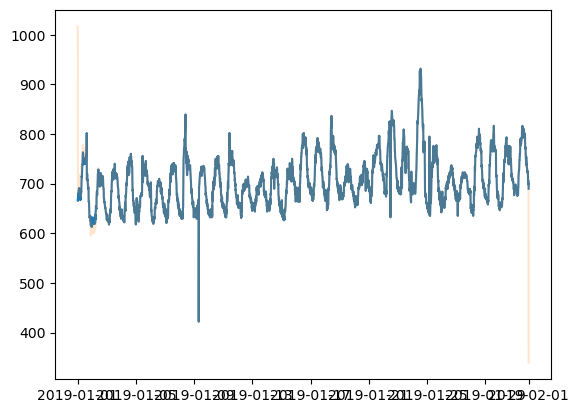

In [93]:
plt.plot(forecast_2019['interval'][0:2976] ,forecast_2019['data'][0:2976])
plt.plot(forecast_2019['interval'][0:2976], (np.array(forecast_2019['data'])-discharge+charge)[0:2976],alpha=.2)
# plt.plot(discharge)#[1000:len(d.value)-10])
# plt.plot(charge)#[1000:len(q.value)-10])

In [211]:
monthly_values_2019

,month,forecasted_or_actual,operation_cost,p,e_0,battery
0,1,forecasted,298955.568243,1420.604907,1706.311173,thermal
1,1,actual,340225.564051,1856.165330,2078.337178,thermal
2,1,actual,340186.780800,1856.160000,0.000000,No
3,2,forecasted,275166.250411,1389.087272,1732.236716,thermal
4,2,actual,310770.747446,1709.280000,2052.180688,thermal
5,2,actual,310981.161600,1709.280000,0.000000,No
6,3,forecasted,318432.999035,1451.743842,1587.223165,thermal
7,3,actual,347548.192222,1836.000000,2069.575548,thermal
8,3,actual,347562.360000,1836.000000,0.000000,No
9,4,forecasted,304417.746240,1408.339829,1620.670772,thermal


# Pre-defined schedule of battery based on peak demand charge ratchets

In [334]:
#say we have a 350 power rated battery (4200 energy rating). charge up fully during non-expensive periods
#For first instance we'll need to use 8 hours to charge (12am-8am)
battery_e = 250*12
cost_battery = 250*12*50 + 250*500
print(f'charge battery to full capacity (100% efficiency) {battery_e/8/4} MW per period from 12am-8am')
#Remember the eta is actually different:
charge_per_period_1 = battery_e/.7/8/4
charge_per_period_rest = battery_e/.7/10/4
print(f'charge battery to full capacity (70% efficiency) {charge_per_period_1} MW per period from 12am-8am and {charge_per_period_rest} from 10pm-8am')
#Check what the discharge is per period
discharge_per_period_no_loss = battery_e/14/4
discharge_per_period = discharge_per_period_no_loss*.7
print(f'discharge full charged battery (70% efficiency) {discharge_per_period} MW per period from 8am-10pm')
print(f'Save {discharge_per_period*4} in peak demand which is ${discharge_per_period*4*18.71} in winter and ${discharge_per_period*4*(9.15 + 18.44 + 16.66)} in summer')
print(f'save {discharge_per_period*4*18.71*8 + discharge_per_period*4*(9.15 + 18.44 + 16.66)*4} annually, or {10*(discharge_per_period*4*18.71*8 + discharge_per_period*4*(9.15 + 18.44 + 16.66)*4)} over 10 years')
print(f'battery cost is {battery_e/12*500+50*battery_e}')

charge battery to full capacity (100% efficiency) 93.75 MW per period from 12am-8am
charge battery to full capacity (70% efficiency) 133.92857142857144 MW per period from 12am-8am and 107.14285714285715 from 10pm-8am
discharge full charged battery (70% efficiency) 37.49999999999999 MW per period from 8am-10pm
Save 149.99999999999997 in peak demand which is $2806.4999999999995 in winter and $6637.499999999999 in summer
save 49001.99999999999 annually, or 490019.99999999994 over 10 years
battery cost is 275000.0


In [260]:
#Charge on a ratchet scale - for first day of the battery, charge in 8 hours, for rest, charge over 10 hours
charge_jan_1_2019_12am_8am = np.tile(np.array([charge_per_period_1]),8*4)
charge_jan_2019_8am_10pm = np.tile(np.array([0]),14*4)
charge_jan_2019_10pm_12am = np.tile(np.array([charge_per_period_rest]),2*4)
charge_jan_1_2019 = np.append(charge_jan_1_2019_12am_8am, np.append(charge_jan_2019_8am_10pm, charge_jan_2019_10pm_12am))
#Can create the charge for the rest of the days using charge_per_period_rest
charge_jan_other_2019_12am_8am = np.tile(np.array([charge_per_period_rest]),8*4)
charge_jan_other_2019 = np.append(charge_jan_other_2019_12am_8am, np.append(charge_jan_2019_8am_10pm, charge_jan_2019_10pm_12am))
charge_2019 = np.append(charge_jan_1_2019, np.tile(charge_jan_other_2019, 364))
sum(charge_jan_other_2019*.7)

3000.0

In [261]:
#Disharge from 8am-10pm every day
discharge_jan_2019_12am_8am = np.tile(np.array([0]),8*4)
discharge_jan_2019_8am_10pm = np.tile(np.array([discharge_per_period]),14*4)  
discharge_jan_2019_10pm_12am = np.tile(np.array([0]),2*4)
discharge_jan_2019 = np.append(discharge_jan_2019_12am_8am, np.append(discharge_jan_2019_8am_10pm, discharge_jan_2019_10pm_12am))
jan_2019_discharge = np.tile(discharge_jan_2019,31)
discharge_2019 = np.tile(discharge_jan_2019,  365)
sum(discharge_jan_2019/.7)

2999.9999999999995

In [262]:
forecast_2019['charge'] = charge_2019
forecast_2019['discharge'] = discharge_2019
forecast_2019['demand_plus_charge'] = forecast_2019['data'] + forecast_2019['charge']
forecast_2019['demand_minus_discharge'] = forecast_2019['data'] - forecast_2019['discharge']
forecast_2019['demand_plus_charge_minus_discharge'] = forecast_2019['data'] - forecast_2019['discharge']+ forecast_2019['charge']
# Add column for rolling sum of current row and preious for demand\n",
forecast_2019['rolling_demand'] = forecast_2019[['data']].rolling(2).sum()
forecast_2019['rolling_demand_plus_charge'] = forecast_2019[['demand_plus_charge']].rolling(2).sum()
forecast_2019['rolling_demand_minus_discharge'] = forecast_2019[['demand_minus_discharge']].rolling(2).sum()
forecast_2019['rolling_demand_plus_charge_minus_discharge'] = forecast_2019[['demand_plus_charge_minus_discharge']].rolling(2).sum()
forecast_2019.head()

,interval,data,forecast,month,charge,discharge,demand_plus_charge,demand_minus_discharge,rolling_demand,rolling_demand_plus_charge,rolling_demand_minus_discharge,demand_plus_charge_minus_discharge,rolling_demand_plus_charge_minus_discharge
0,2019-01-01 00:00:00,666.72,686.802478,1,133.928571,0.0,800.648571,666.72,NaN,NaN,NaN,800.648571,NaN
1,2019-01-01 00:15:00,665.28,687.262579,1,133.928571,0.0,799.208571,665.28,1332.00,1599.857143,1332.00,799.208571,1599.857143
2,2019-01-01 00:30:00,679.68,691.316724,1,133.928571,0.0,813.608571,679.68,1344.96,1612.817143,1344.96,813.608571,1612.817143
3,2019-01-01 00:45:00,676.80,690.248117,1,133.928571,0.0,810.728571,676.80,1356.48,1624.337143,1356.48,810.728571,1624.337143
4,2019-01-01 01:00:00,681.12,686.298023,1,133.928571,0.0,815.048571,681.12,1357.92,1625.777143,1357.92,815.048571,1625.777143


In [315]:
#Find peak location with battery and without
peak_loc_battery = pd.DataFrame(forecast_2019['month'].unique(), forecast_2019.loc[forecast_2019.groupby('month')['rolling_demand_plus_charge_minus_discharge'].idxmax(),'interval']).reset_index()
peak_loc_battery.columns = ['peak_loc_battery', 'month']
peak_loc_baseline = pd.DataFrame(forecast_2019['month'].unique(), forecast_2019.loc[forecast_2019.groupby('month')['rolling_demand'].idxmax(),'interval']).reset_index()
peak_loc_baseline.columns = ['peak_loc_baseline', 'month']
# peak_loc_baseline['interval'][0] < datetime(2019,1,24, 13,46,0)
peak_loc_battery

,peak_loc_battery,month
0,2019-01-24 13:45:00,1
1,2019-02-15 07:45:00,2
2,2019-03-12 07:30:00,3
3,2019-04-19 14:45:00,4
4,2019-05-20 07:30:00,5
5,2019-06-25 23:00:00,6
6,2019-07-20 07:30:00,7
7,2019-08-19 16:30:00,8
8,2019-09-12 07:45:00,9
9,2019-10-02 13:45:00,10


In [329]:
scheduled_results = pd.DataFrame(forecast_2019.groupby('month').agg(
    {'demand_plus_charge_minus_discharge':'sum',
    'rolling_demand_plus_charge_minus_discharge': 'max',
    'data':'sum',
    'rolling_demand':'max'})).reset_index()
scheduled_results.columns = ['month', 'demand_w_battery', 'p_battery','demand','p']
scheduled_results = scheduled_results.merge(peak_loc_battery,how='left', on='month')
scheduled_results = scheduled_results.merge(peak_loc_baseline,how='left', on='month')
scheduled_results['peak_time_battery'] = scheduled_results['peak_loc_battery'].apply(lambda x: x.time())
scheduled_results['B_battery'] = np.where(scheduled_results['month'].isin([6,7,8,9]), np.where(
    #summer - Time before 8am
    scheduled_results['peak_time_battery']< time(8,0,0), 16.66, np.where(
        #summer - Time 8am-6pm
        scheduled_results['peak_time_battery'] < time(18,0,0), 16.66+18.44+9.15, np.where(
            #summer - time 6pm-10pm
            scheduled_results['peak_time_battery'] < time(22,0,0), 16.66 + 18.44, 16.66))), np.where(
                #Time before 8am
                scheduled_results['peak_time_battery']< time(8,0,0), 4.21, np.where(
                    #Time 8am-10pm
                    scheduled_results['peak_time_battery'] < time(22,0,0), 4.21+13.96, 4.21)))
scheduled_results['peak_time_baseline'] = scheduled_results['peak_loc_baseline'].apply(lambda x: x.time())
scheduled_results['B_baseline'] = np.where(scheduled_results['month'].isin([6,7,8,9]), np.where(
    #summer - Time before 8am
    scheduled_results['peak_time_baseline']< time(8,0,0), 16.66, np.where(
        #summer - Time 8am-6pm
        scheduled_results['peak_time_baseline'] < time(18,0,0), 16.66+18.44+9.15, np.where(
            #summer - time 6pm-10pm
            scheduled_results['peak_time_baseline'] < time(22,0,0), 16.66 + 18.44, 16.66))), np.where(
                #Time before 8am
                scheduled_results['peak_time_baseline']< time(8,0,0), 4.21, np.where(
                    #Time 8am-10pm
                    scheduled_results['peak_time_baseline'] < time(22,0,0), 4.21+13.96, 4.21)))
scheduled_results

,month,demand_w_battery,p_battery,demand,p,peak_loc_battery,peak_loc_baseline,peak_time_battery,B_battery,peak_time_baseline,B_baseline
0,1,2.166568e+06,1781.160000,2097953.28,1856.16,2019-01-24 13:45:00,2019-01-24 13:45:00,13:45:00,18.17,13:45:00,18.17
1,2,1.975553e+06,1838.605714,1914353.28,1709.28,2019-02-15 07:45:00,2019-02-05 11:00:00,07:45:00,4.21,11:00:00,18.17
2,3,2.228081e+06,1772.365714,2160324.00,1836.00,2019-03-12 07:30:00,2019-03-15 15:45:00,07:30:00,4.21,15:45:00,18.17
3,4,2.225895e+06,1933.800000,2160324.00,2008.80,2019-04-19 14:45:00,2019-04-19 14:45:00,14:45:00,18.17,14:45:00,18.17
4,5,2.422792e+06,2125.165714,2355035.04,2112.48,2019-05-20 07:30:00,2019-05-20 11:30:00,07:30:00,4.21,11:30:00,18.17
5,6,2.637433e+06,2372.845714,2571861.60,2384.64,2019-06-25 23:00:00,2019-06-25 15:00:00,23:00:00,16.66,15:00:00,44.25
6,7,3.093487e+06,2708.365714,3025729.44,2698.56,2019-07-20 07:30:00,2019-07-19 16:30:00,07:30:00,16.66,16:30:00,44.25
7,8,2.889839e+06,2521.320000,2822081.76,2596.32,2019-08-19 16:30:00,2019-08-19 16:30:00,16:30:00,44.25,16:30:00,44.25
8,9,2.570146e+06,2293.645714,2504574.72,2295.36,2019-09-12 07:45:00,2019-09-11 17:00:00,07:45:00,16.66,17:00:00,44.25
9,10,2.450568e+06,2295.240000,2382811.20,2370.24,2019-10-02 13:45:00,2019-10-02 13:45:00,13:45:00,18.17,13:45:00,18.17


In [332]:
scheduled_results['op_costs_battery'] = scheduled_results['B_battery']*scheduled_results['p_battery']*2 + .13*scheduled_results['demand_w_battery']
scheduled_results['op_costs_baseline'] = scheduled_results['B_baseline']*scheduled_results['p']*2 + .13*scheduled_results['demand']
scheduled_results['saved_cost'] = scheduled_results['op_costs_baseline'] - scheduled_results['op_costs_battery']
scheduled_results

,month,demand_w_battery,p_battery,demand,p,peak_loc_battery,peak_loc_baseline,peak_time_battery,B_battery,peak_time_baseline,B_baseline,op_costs_battery,op_costs_baseline,saved_cost
0,1,2.166568e+06,1781.160000,2097953.28,1856.16,2019-01-24 13:45:00,2019-01-24 13:45:00,13:45:00,18.17,13:45:00,18.17,346381.137943,340186.7808,-6194.357143
1,2,1.975553e+06,1838.605714,1914353.28,1709.28,2019-02-15 07:45:00,2019-02-05 11:00:00,07:45:00,4.21,11:00:00,18.17,272302.986514,310981.1616,38678.175086
2,3,2.228081e+06,1772.365714,2160324.00,1836.00,2019-03-12 07:30:00,2019-03-15 15:45:00,07:30:00,4.21,15:45:00,18.17,304573.867886,347562.3600,42988.492114
3,4,2.225895e+06,1933.800000,2160324.00,2008.80,2019-04-19 14:45:00,2019-04-19 14:45:00,14:45:00,18.17,14:45:00,18.17,359640.697714,353841.9120,-5798.785714
4,5,2.422792e+06,2125.165714,2355035.04,2112.48,2019-05-20 07:30:00,2019-05-20 11:30:00,07:30:00,4.21,11:30:00,18.17,332856.879086,382922.0784,50065.199314
5,6,2.637433e+06,2372.845714,2571861.60,2384.64,2019-06-25 23:00:00,2019-06-25 15:00:00,23:00:00,16.66,15:00:00,44.25,421929.512914,545382.6480,123453.135086
6,7,3.093487e+06,2708.365714,3025729.44,2698.56,2019-07-20 07:30:00,2019-07-19 16:30:00,07:30:00,16.66,16:30:00,44.25,492396.001371,632167.3872,139771.385829
7,8,2.889839e+06,2521.320000,2822081.76,2596.32,2019-08-19 16:30:00,2019-08-19 16:30:00,16:30:00,44.25,16:30:00,44.25,598815.877371,596644.9488,-2170.928571
8,9,2.570146e+06,2293.645714,2504574.72,2295.36,2019-09-12 07:45:00,2019-09-11 17:00:00,07:45:00,16.66,17:00:00,44.25,410543.274514,528734.0736,118190.799086
9,10,2.450568e+06,2295.240000,2382811.20,2370.24,2019-10-02 13:45:00,2019-10-02 13:45:00,13:45:00,18.17,13:45:00,18.17,401982.906171,395899.9776,-6082.928571


In [335]:
sum(scheduled_results['saved_cost']) - cost_battery

257375.86411428568

In [278]:
aug_2019 = forecast_2019[forecast_2019['month'] == 1].reset_index()
orig_peak_loc = aug_2019.loc[aug_2019['rolling_demand'].argmax()]['interval']
new_peak_loc = aug_2019.loc[aug_2019['rolling_demand_plus_charge_minus_discharge'].argmax()]['interval']
if  new_peak_loc== orig_peak_loc:
    print('battery did not change the location of the peak demand periods')
else:
    print(f'battery did change peak location from {orig_peak_loc} to {new_peak_loc}')

battery did not change the location of the peak demand periods


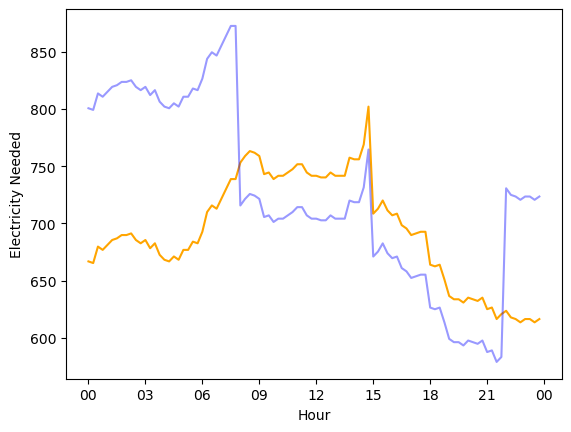

In [295]:
start_idx = 0
end_idx = 96
_ = plt.plot(forecast_2019['interval'][start_idx:end_idx], forecast_2019['data'][start_idx:end_idx], color='orange')
_ = plt.plot(forecast_2019['interval'][start_idx:end_idx], forecast_2019['demand_plus_charge_minus_discharge'][start_idx:end_idx], alpha=.4, color='blue')
_ = plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
_ = plt.xlabel('Hour')
_ = plt.ylabel('Electricity Needed')
# _ = plt.xticks(rotations=45)

In [ ]:
#need to incorporate something about how to account for differences in forecasted vs. actual demand?
#Maybe not because we are shaving the demand no matter what
#Would this increase in charge change the demand in the non-expensive periods to be more than peak - confirm that charging doesn't change the peak


In [169]:
jan_2019_summary = pd.DataFrame(columns=['timestamp', 'demand','charge', 'discharge', 'demand_plus_charge'])
jan_2019_summary['timestamp'] = forecast_2019[forecast_2019['month'] == 1]['interval']
jan_2019_summary['demand'] = forecast_2019[forecast_2019['month'] == 1]['data']
jan_2019_summary['charge'] = jan_2019_charge
jan_2019_summary['discharge'] = jan_2019_discharge
jan_2019_summary['demand_plus_charge'] = jan_2019_summary['demand'] + jan_2019_summary['charge']
jan_2019_summary['demand_minus_discharge'] = jan_2019_summary['demand'] - jan_2019_summary['discharge']
# Add column for rolling sum of current row and preious for demand\n",
jan_2019_summary['rolling_demand'] = jan_2019_summary[['demand']].rolling(2).sum()
jan_2019_summary['rolling_demand_plus_charge'] = jan_2019_summary[['demand_plus_charge']].rolling(2).sum()
jan_2019_summary['rolling_demand_minus_discharge'] = jan_2019_summary[['demand_minus_discharge']].rolling(2).sum()
jan_2019_summary.head()


,timestamp,demand,charge,discharge,demand_plus_charge,demand_minus_discharge,rolling_demand,rolling_demand_plus_charge,rolling_demand_minus_discharge
0,2019-01-01 00:00:00,666.72,133.928571,0.0,800.648571,666.72,NaN,NaN,NaN
1,2019-01-01 00:15:00,665.28,133.928571,0.0,799.208571,665.28,1332.00,1599.857143,1332.00
2,2019-01-01 00:30:00,679.68,133.928571,0.0,813.608571,679.68,1344.96,1612.817143,1344.96
3,2019-01-01 00:45:00,676.80,133.928571,0.0,810.728571,676.80,1356.48,1624.337143,1356.48
4,2019-01-01 01:00:00,681.12,133.928571,0.0,815.048571,681.12,1357.92,1625.777143,1357.92


In [176]:
if jan_2019_summary.loc[jan_2019_summary['rolling_demand_plus_charge'].argmax()]['timestamp'] == jan_2019_summary.loc[jan_2019_summary['rolling_demand'].argmax()]['timestamp']:
    print('charging did not change the peak demand periods')

charging did not change the peak demand periods


In [178]:
if jan_2019_summary.loc[jan_2019_summary['rolling_demand_minus_discharge'].argmax()]['timestamp'] == jan_2019_summary.loc[jan_2019_summary['rolling_demand'].argmax()]['timestamp']:
    print('discharging did not change the peak demand periods')

discharging did not change the peak demand periods


In [177]:
jan_2019_summary.loc[jan_2019_summary['rolling_demand'].argmax()-1:jan_2019_summary['rolling_demand'].argmax()]

,timestamp,demand,charge,discharge,demand_plus_charge,demand_minus_discharge,rolling_demand,rolling_demand_plus_charge,rolling_demand_minus_discharge
2262,2019-01-24 13:30:00,931.68,0.0,37.5,931.68,894.18,1854.72,1854.72,1779.72
2263,2019-01-24 13:45:00,924.48,0.0,37.5,924.48,886.98,1856.16,1856.16,1781.16


In [187]:
print(f'monthly cost of inefficiency {(battery_e/.7-battery_e)*31*.13}')

monthly cost of inefficiency 5181.428571428573


In [ ]:
#now just need to re-run the optimization with the actual demand, charge, discharge, but actually I don't because it's static

In [ ]:
#Run optimization for actual demand
monthly_cost_act, cost_E_act, cost_P_act, e_act, p_act, d_act, q_act = run_optimization_actual_demand(
    D = demand_array_forecast,
    P = 350,
    battery = 'thermal',
    month = month,
    e_0=0)

In [25]:
thermal_350 = pd.DataFrame(columns=['month', 'monthly_cost', 'cost_E', 'cost_P', 'P', 'battery_type', 'end_e'])
power = 350
battery = 'thermal'
for month in range(1,13):
    print(f'Optimizing {month}/2019 with {power} kW {battery} battery...')
    demand_array = np.array(forecast_2019[forecast_2019['month'] == month]['forecast'])
    if month == 1:
        monthly_cost, cost_E, cost_P, e, p, d, q = run_optimization(D = demand_array, P = power, battery = battery, month = month, e_0=0)
        #update the energy stored in the battery based on the final period
        e_0 = e.value[-1]
    else:
        monthly_cost, cost_E, cost_P, e, p, d, q = run_optimization(D = demand_array, P = power, battery = battery, month = month, e_0=e_0)
        #update the energy stored in the battery based on the final period
        e_0 = e.value[-1]
    thermal_350.loc[len(thermal_350.index)] =[month, monthly_cost, cost_E,cost_P, power, battery, e_0]

Optimizing 1/2019 with 350 kW thermal battery...
Optimizing 2/2019 with 350 kW thermal battery...
Optimizing 3/2019 with 350 kW thermal battery...


In [60]:
#Add the zero battery option
power = 0
battery = 'No'
for month in range(1,13):
    print(f'Optimizing {month}/2018 with {power} kW {battery} battery...')
    demand_array = np.array(forecast_2019[forecast_2019['month'] == month]['forecast'])
    if month == 1:
        monthly_cost, cost_E, cost_P, e, p, d, q, obj_cost  = run_optimization(D = demand_array, P = power, battery = battery, month = month, e_0=0)
        #update the energy stored in the battery based on the final period
        e_0 = e.value[-1]
    else:
        print(e_0)
        monthly_cost, cost_E, cost_P, e, p, d, q, obj_cost  = run_optimization(D = demand_array, P = power, battery = battery, month = month, e_0=e_0)
        #update the energy stored in the battery based on the final period
        e_0 = e.value[-1]
    thermal_350.loc[len(thermal_350.index)] =[month, monthly_cost, cost_E,cost_P, power, battery, e_0]

Optimizing 1/2018 with 0 kW No battery...
optimizing without battery...
Optimizing 2/2018 with 0 kW No battery...
0.0
optimizing without battery...
Optimizing 3/2018 with 0 kW No battery...
0.0
optimizing without battery...
Optimizing 4/2018 with 0 kW No battery...
0.0
optimizing without battery...
Optimizing 5/2018 with 0 kW No battery...
0.0
optimizing without battery...
Optimizing 6/2018 with 0 kW No battery...
0.0
optimizing without battery...
Optimizing 7/2018 with 0 kW No battery...
0.0
optimizing without battery...
Optimizing 8/2018 with 0 kW No battery...
0.0
optimizing without battery...
Optimizing 9/2018 with 0 kW No battery...
0.0
optimizing without battery...
Optimizing 10/2018 with 0 kW No battery...
0.0
optimizing without battery...
Optimizing 11/2018 with 0 kW No battery...
0.0
optimizing without battery...
Optimizing 12/2018 with 0 kW No battery...
0.0
optimizing without battery...


In [62]:
cost_0 = round(np.sum(thermal_350[thermal_350['P'] == 0]['monthly_cost']),0)
for battery in ['thermal']:
    print(f'{battery} results:')
    battery_results = thermal_350[thermal_350['battery_type'] == battery]
    for P in battery_results['P'].unique():
        cost = round(np.sum(battery_results[battery_results['P'] == P]['monthly_cost']),0)
        cost_diff =  cost_0 - cost
        long_term_cost_diff = cost_diff*10
        battery_cost = round(battery_results[battery_results['P'] == P]['cost_E'].unique().item()+battery_results[battery_results['P'] == P]['cost_P'].unique().item(),0)
        print(f'\t{P}kW {battery} battery: ${cost:,} operating and ${battery_cost:,} for battery - 10-year amount saved: ${long_term_cost_diff-battery_cost:,}' )

thermal results:
	350kW thermal battery: $4,494,140.0 operating and $385,000 for battery - 10-year amount saved: $101,070.0
